Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


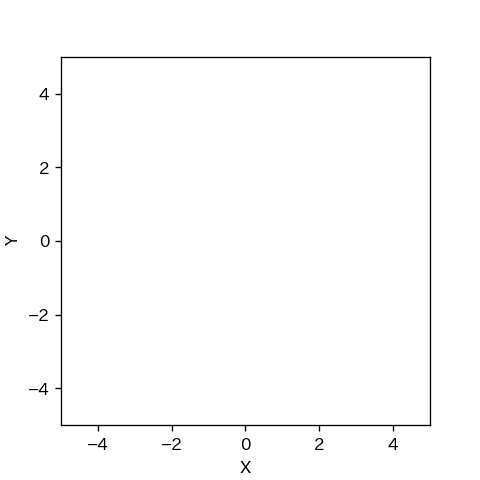

In [1]:
import sys
sys.path.append("../scripts/")
from mcl import *

In [2]:
class ResetMcl(Mcl):
    def __init__(self,envmap,init_pose,num,motion_noise_stds={"nn":0.19,"no":0.001,"on":0.13,"oo":0.2},
                distance_dev_rate=0.14,direction_dev=0.05,alpha_threshold=0.001,expansion_rate=0.2):
        super().__init__(envmap,init_pose,num,motion_noise_stds,distance_dev_rate,direction_dev)
        self.alpha_threshold=alpha_threshold
        self.expansion_rate=expansion_rate
        self.counter=0
        
    def random_reset(self):
         for p in self.particles:
                p.pose=np.array([np.random.uniform(-5.0,5,0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
                p.weight=1/len(self.particles)
    
    def sensor_resetting_draw(self,particle,landmark_pos,ell_obs,phi_obs):
             ##パーティクルの位置を決める##
                psi=np.random.uniform(-np.pi,np.pi) #ランドマークからの方角を選ぶ
                ell=norm(loc=ell_obs,scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
                particle.pose[0]=landmark_pos[0]+ell*math.cos(psi)
                particle.pose[1]=landmark_pos[1]+ell*math.sin(psi)
                
            ##パーティクルの向きを決める##
                phi=norm(loc=phi_obs,scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
                particle.pose[2]=math.atan2(landmark_pos[1]-particle.pose[1],landmark_pos[0]-particle.pose[0])-phi
            
                particle.weight=1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self,observation):
        nearest_obs=np.argmin([obs[0][0] for obs in observation]) #距離が一番近いランドマークを選択
        values, landmark_id=observation[nearest_obs]
        
        for p in self.particles:
            self.sensor_resetting_draw(p,self.map.landmarks[landmark_id].pos,*values)
            
        print(list([obs[0][0] for obs in observation]))
            
    def expansion_resetting(self):
        for p in self.particles:
            p.pose+=multivariate_normal(cov=np.eye(3)*(self.expansion_rate**2)).rvs()
            p.weight=1.0/len(self.particles)
            
    def observation_update(self,observation):
        for p in self.particles:
            p.observation_update(observation,self.map,self.distance_dev_rate,self.direction_dev)
     
        self.set_ml()
        
        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.counter += 1
            if self.counter < 5:
                self.expansion_resetting() #expansion_resettingに変更
            else:
                self.sensor_resetting(observation)
        else:
            self.counter=0
            self.resampling()

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [3]:
def trial_kidnap(animation): ###mclkidnap1test
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    robot_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m),agent=a,color="red")
    world.append(r)
    
    world.draw()
    
    return(r.pose, pf.ml.pose)

<IPython.core.display.Javascript object>


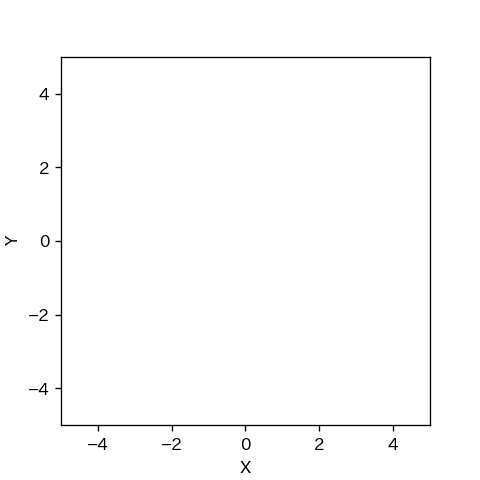

(array([ 0.97683407, -0.33390787, -2.21140445]),
 array([ 0.43738569, -0.32524093, -2.42338317]))

In [4]:
trial_kidnap(True)

In [5]:
if __name__=='__main__': ###mclglobal1exec
    ok=0
    for i in range(1000):
        actual, estm=trial_kidnap(False)
        diff = math.sqrt((actual[0]-estm[0])**2 + (actual[1]-estm[1])**2)
        print(i, "真値:",actual, "推定値:", estm, "誤差:", diff)
        if diff<=1.0:
            ok += 1
            print(ok)

0 真値: [-5.6385304   3.59858594  5.52835017] 推定値: [-2.14935348  1.40459172  2.82686308] 誤差: 4.12164605175372
[3.0272524289263565]
1 真値: [-1.2277996  -3.10810718  5.17708143] 推定値: [-1.85391802 -3.20227814  4.91469981] 誤差: 0.6331606730050564
1
2 真値: [-0.6540768  -1.95221116  7.02439655] 推定値: [-0.45183533 -2.28175669  7.07437852] 誤差: 0.3866547076968882
2
[2.452011373257245]
[6.56353802814661]
3 真値: [-0.62934127  3.87730913  4.76989705] 推定値: [-5.52876707  5.53352097 -0.06398645] 誤差: 5.171789906596179
[2.2821237126698057]
4 真値: [ 2.92836238 -0.18489084  3.39731567] 推定値: [2.68067853 0.07704137 3.52925805] 誤差: 0.3604937906774197
3
5 真値: [ 0.34147308 -1.61970586  5.71578724] 推定値: [ 0.44248907 -1.31393098  5.56447983] 誤差: 0.3220287438079868
4
[5.521771611003078]
6 真値: [-1.98121457 -5.4355729   1.92552631] 推定値: [-1.10720204 -5.63365585  2.1235358 ] 誤差: 0.8961778576543724
5
[4.450290089756224]
[4.820209610814104]
7 真値: [-1.88499444 -1.89606419  3.33828799] 推定値: [-7.67350927  1.54903391  1.0190944 

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


[2.792215923439834]
20 真値: [ 4.40549401 -0.53809395  2.5027425 ] 推定値: [4.40526631 0.21460495 2.61920751] 誤差: 0.7526989374803557
12
[3.625620382551146]
21 真値: [ 3.95568927 -4.26097877  2.88512487] 推定値: [ 0.85168036 -4.56637256  1.20435354] 誤差: 3.118996097884903
[1.253808877472976]
[5.825263468949428, 0.9904407526236317]
22 真値: [3.26523517 5.16031911 2.91438935] 推定値: [3.60660296 5.52037731 2.53677686] 誤差: 0.49615911933042506
13
[3.413247707417714]
23 真値: [-0.2680053   0.90212648  5.10344557] 推定値: [-0.755646    0.42511499  5.1756963 ] 誤差: 0.6821535120894308
14
[4.227352305114833]
24 真値: [0.97200905 1.30876268 9.71399337] 推定値: [0.76785687 1.5774968  9.76240805] 誤差: 0.3374850201261595
15
[2.4387526937992496]
25 真値: [3.8672906  3.08969785 3.094779  ] 推定値: [3.8370066  3.12071906 3.20514166] 誤差: 0.04335245600314023
16
[5.929239536935427]
26 真値: [-2.5892333  -2.43735733  4.17570619] 推定値: [-1.18255602  5.5123478  -0.18254246] 誤差: 8.073199650232558
[1.9819626921984357]
27 真値: [-3.58413713  2.0653